# Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torchinfo import summary
import torch.nn.functional as F
from operator import add

/home/raouti/.local/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
PATCH_SIZE = 256
OVERLAP = '50'

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Downsampling (encoder) blocks
        self.enc1 = MultiPathBlock(in_channels = 1, out_channels = 16, stride=1, dilation= [1,3,5,7])
        self.enc2 = MultiPathBlock(in_channels = 16, out_channels = 32, stride=1, dilation= [1,3,5])
        self.enc3 = MultiPathBlock(in_channels = 32, out_channels = 64, stride=1, dilation= [1,3])
        self.enc4 = MultiPathBlock(in_channels = 64, out_channels = 128, stride=1, dilation= [1])

        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)

        # Upsampling (decoder) blocks
        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec4 = MultiPathBlock(in_channels = 128 + 128, out_channels = 128, stride=1, dilation= [1])

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = MultiPathBlock(in_channels = 64 + 64, out_channels = 64, stride=1, dilation= [1,3])

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = MultiPathBlock(in_channels = 32 + 32, out_channels = 32, stride=1, dilation= [1,3,5])

        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec1 = MultiPathBlock(in_channels = 16 + 16, out_channels = 16, stride=1, dilation= [1,3,5,7])

        # Final output layer
        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)


        # Intermediate Layers
        self.out_2 = self.conv_block_intermediate_output(32, 1)
        self.out_3 = self.conv_block_intermediate_output(64, 1)
        self.out_4 = self.conv_block_intermediate_output(128, 1)
    
    def conv_block_intermediate_output(self, in_channels, out_channels):
        return nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, dilation=1, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,  kernel_size = 3, dilation=1,padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoder path
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)
        out_d4 = self.out_4(d4)  

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)
        out_d3 = self.out_3(d3)  

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)
        out_d2 = self.out_2(d2)  

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        # Final output
        out = self.final_conv(d1)
        return out, out_d4, out_d3, out_d2  

# Define the Standard Convolution 
class StandardConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dilation=1):
        super(StandardConvBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class SinglePathBlock(nn.Module):
    def __init__(self,in_channels, out_channels, stride=1, dilation= 1):
        super(SinglePathBlock,self).__init__()
        
        self.single_path_block_1 =  nn.Sequential(
            StandardConvBlock(in_channels, out_channels, stride=stride, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            )
        
        self.single_path_block_2 =  nn.Sequential(
            StandardConvBlock(out_channels, out_channels, stride=stride, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            CBAM(out_channels),
            nn.ReLU(),
            )
        
        self.channel_modification = nn.Conv2d(in_channels,out_channels,kernel_size = 1)

    def forward(self,x):

        identity = x
        out_block_1 = self.single_path_block_1(x)
        
        if out_block_1.shape[1] != x.shape[1]:
            identity = self.channel_modification(x)
        
        out_block_2 = self.single_path_block_2(out_block_1)
        
        out_block_2 = out_block_2 + identity

        return out_block_2


class MultiPathBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dilation= [1, 3, 5, 7]):
        super(MultiPathBlock, self).__init__()
        
        self.parallel_paths = nn.ModuleList([
            SinglePathBlock(in_channels, out_channels, stride=1, dilation= d)
            for d in dilation
        ])

    def forward(self, x):
        out = 0
        for path in self.parallel_paths:
            out += path(x)

        return out

class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction_ratio, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, stride=1, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        channel_attention = self.channel_attention(x)
        x = x * channel_attention
        max_pool = torch.max(x, dim=1, keepdim=True)[0]
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        spatial_attention = self.spatial_attention(torch.cat([max_pool, avg_pool], dim=1))
        x = x * spatial_attention
        return x

In [ ]:
MODEL = UNet()
(summary(model=MODEL,
          input_size=(32, 1, PATCH_SIZE, PATCH_SIZE), 
          col_names=["input_size", "output_size", "num_params", "trainable"],
          col_width=20,
          row_settings=["var_names"]
  ))

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                                                       [32, 1, 256, 256]    [32, 1, 256, 256]    --                   True
├─MultiPathBlock (enc1)                                           [32, 1, 256, 256]    [32, 16, 256, 256]   --                   True
│    └─ModuleList (parallel_paths)                                --                   --                   --                   True
│    │    └─SinglePathBlock (0)                                   [32, 1, 256, 256]    [32, 16, 256, 256]   2,738                True
│    │    └─SinglePathBlock (1)                                   [32, 1, 256, 256]    [32, 16, 256, 256]   2,738                True
│    │    └─SinglePathBlock (2)                                   [32, 1, 256, 256]    [32, 16, 256, 256]   2,738                True
│    │    └─SinglePathBlock (3)                          

# LOAD DATASET

In [ ]:
train_image_dir = '/scratch/raouti/FUNDUS_DATASETS/IDRID/IDRID_NOV_2024/PREPROCESSED/AUGMENTED/OD_FOLDER/OD_ORIGINAL_AUG/train/image/'
train_mask_dir =  '/scratch/raouti/FUNDUS_DATASETS/IDRID/IDRID_NOV_2024/PREPROCESSED/AUGMENTED/OD_FOLDER/OD_ORIGINAL_AUG/train/mask/'
test_image_dir =  '/scratch/raouti/FUNDUS_DATASETS/IDRID/IDRID_NOV_2024/PREPROCESSED/AUGMENTED/OD_FOLDER/OD_ORIGINAL_AUG/test/image/'
test_mask_dir =   '/scratch/raouti/FUNDUS_DATASETS/IDRID/IDRID_NOV_2024/PREPROCESSED/AUGMENTED/OD_FOLDER/OD_ORIGINAL_AUG/test/mask/'

In [9]:
print(train_image_dir)
print(train_mask_dir)
print(test_image_dir)
print(test_mask_dir)

/scratch/raouti/FUNDUS_DATASETS/IDRID/IDRID_NOV_2024/PREPROCESSED/AUGMENTED/OD_FOLDER/OD_ORIGINAL_AUG/train/image/
/scratch/raouti/FUNDUS_DATASETS/IDRID/IDRID_NOV_2024/PREPROCESSED/AUGMENTED/OD_FOLDER/OD_ORIGINAL_AUG/train/mask/
/scratch/raouti/FUNDUS_DATASETS/IDRID/IDRID_NOV_2024/PREPROCESSED/AUGMENTED/OD_FOLDER/OD_ORIGINAL_AUG/test/image/
/scratch/raouti/FUNDUS_DATASETS/IDRID/IDRID_NOV_2024/PREPROCESSED/AUGMENTED/OD_FOLDER/OD_ORIGINAL_AUG/test/mask/


In [10]:
img_testing = sorted(os.listdir(train_image_dir))
lab_testing = sorted(os.listdir(train_mask_dir))
print(len(img_testing))
img_path = os.path.join(train_image_dir,img_testing[10])
mask_path = os.path.join(train_mask_dir, lab_testing[10])
IMAGE = Image.open(img_path)
LAB = Image.open(mask_path)

216


In [11]:
image_transform = transforms.Compose([
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
    transforms.ToTensor()
])

IMAGE_TESTING = image_transform(IMAGE)
LAB_TESTING = image_transform(LAB)

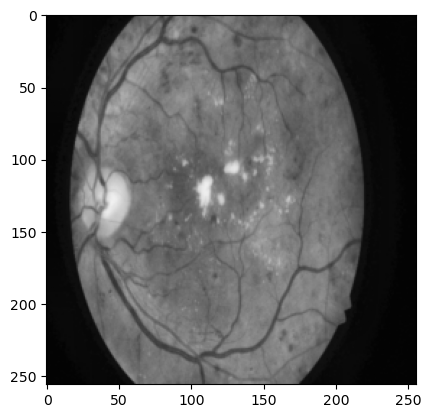

In [12]:
plt.imshow(IMAGE_TESTING.permute(1,2,0),cmap = 'gray')

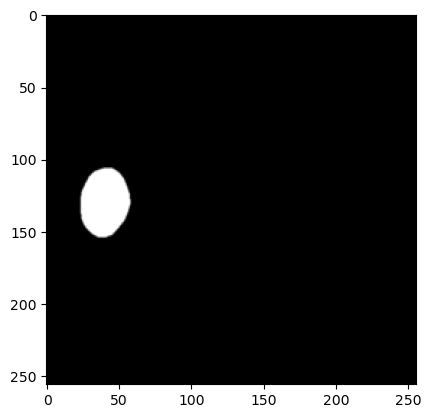

In [13]:
plt.imshow(LAB_TESTING.permute(1,2,0),cmap = 'gray')

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.labels = os.listdir(mask_dir)
        self.images.sort()
        self.labels.sort()


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.labels[idx])
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        image = np.array(Image.open(img_path).convert("L"))  
        mask = np.array(Image.open(mask_path).convert("L")) 

        if self.transform:

            transformed = self.transform(image=image, mask=mask)
            image = transformed['image'].float()/255
            mask = transformed['mask'].unsqueeze(0).float()/255

        return image, mask

In [ ]:
train_transform = A.Compose([A.Resize(PATCH_SIZE,PATCH_SIZE),  
                                        ToTensorV2() 
                                        ])

val_transform = A.Compose([A.Resize(PATCH_SIZE,PATCH_SIZE),
                                    ToTensorV2() 
                                     ])


train_dataset = SegmentationDataset(image_dir=train_image_dir, mask_dir=train_mask_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = SegmentationDataset(image_dir=test_image_dir, mask_dir=test_mask_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:
img,lab= next(iter(train_loader))

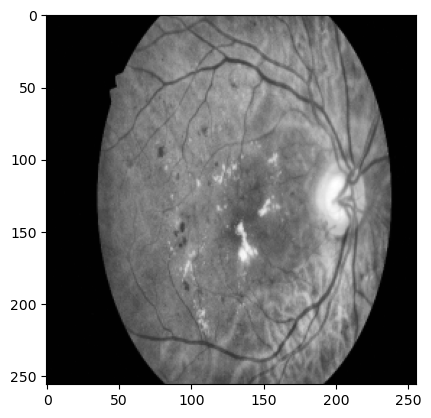

In [19]:
plt.imshow(torch.permute(img[3],(1,2,0)),cmap = 'gray')

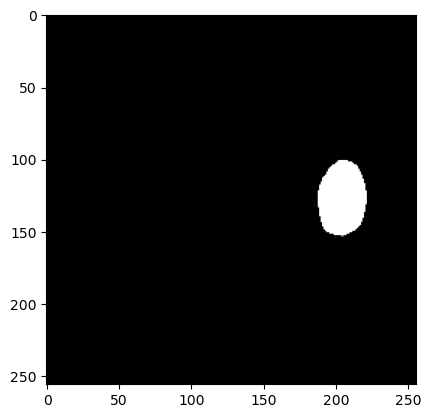

In [20]:
plt.imshow(torch.permute(lab[3],(1,2,0)),cmap = 'gray')

# Training

In [ ]:
def train(model, loader, optimizer, criterion, device,scheduler):
    model.train()


    total_loss = 0
    len_loader = len(loader)
    max_grad_norm = 1

    for idx,(images, masks) in enumerate(loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()


        outputs, out_d4, out_d3, out_d2 = model(images)       
        loss = LOSS_FUNC(outputs, out_d4, out_d3, out_d2, masks, criterion)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    print(f"_______________________Training - __________________________________")
    epoch_loss = total_loss/ len_loader
    return  epoch_loss

def validate(model, loader, criterion, device,scheduler):

    model.eval()
    total_loss = 0
    len_loader = len(loader)
    with torch.no_grad():
        for idx,(images, masks) in enumerate(loader):
            images, masks = images.to(device), masks.to(device)

            outputs, out_d4, out_d3, out_d2 = model(images)
            loss = LOSS_FUNC(outputs, out_d4, out_d3, out_d2, masks, criterion)
        
            
            total_loss += loss.item()
    scheduler.step(loss)
    print(f"_______________________Validation - __________________________________")
    epoch_loss = total_loss/ len_loader
    return  epoch_loss

# Loss Function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

def LOSS_FUNC(segmentation_head, aux_out1, aux_out2, aux_out3, masks, criterion):
    loss_head = criterion(segmentation_head, masks)

    mask_aux_1_resized = F.interpolate(masks, size=aux_out1.shape[2:], mode='bilinear', align_corners=True)
    loss_aux1 = criterion(aux_out1, mask_aux_1_resized)

    mask_aux_2_resized = F.interpolate(masks, size=aux_out2.shape[2:], mode='bilinear', align_corners=True)
    loss_aux2 = criterion(aux_out2, mask_aux_2_resized)

    mask_aux_3_resized = F.interpolate(masks, size=aux_out3.shape[2:], mode='bilinear', align_corners=True)
    loss_aux3 = criterion(aux_out3, mask_aux_3_resized)

    total_loss = loss_head + (0.3 * loss_aux1) + (0.2 * loss_aux2) + (0.1 * loss_aux3)

    return total_loss

In [24]:
model_name = 'IDRID_OPTIC_DISC'
checkpoint_name = f'RESULTS/{model_name}/RUN'
log_file_name = f'RESULTS/{model_name}/training_log.txt'
folder_path = f"RESULTS/{model_name}/"  
folder_path

'RESULTS/IDRID_OPTIC_DISC/'

In [ ]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.utils as utils
from torch.optim.lr_scheduler import ReduceLROnPlateau


criterion = DiceBCELoss()
num_epochs = 100  
patience = 10  
num_runs = 10  
best_valid_losses = [] 

initial_lr = 0.001
weight_decay = 0.01 
momentum_value = 0.9
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(log_file_name, 'w') as log_file:
        log_file.write(f"STARTING")
    
for run in range(num_runs):
    
    print(f"Starting run {run+1}/{num_runs}")
    print(f"MODEL INTIALIZATION")
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=initial_lr, betas=(0.9, 0.999))  
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    with open(log_file_name, 'a') as log_file:
        log_file.write(f"RUN NO {run+1}/{num_runs}\n")
        log_file.write("MODEL INTIALIZATION \n")

    best_valid_loss = float("inf")
    total_train_loss = []
    total_val_loss = []
    early_stopping_counter = 0 

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device, scheduler)
        valid_loss = validate(model, val_loader, criterion, device, scheduler)
        
        total_train_loss.append(train_loss)
        total_val_loss.append(valid_loss)
    
        if valid_loss < best_valid_loss:
            checkpoint_path = f"{checkpoint_name}_{run+1}.pth"
            print(f"Valid loss improved from {best_valid_loss:.3f} to {valid_loss:.3f}. Saving checkpoint: {checkpoint_path}")
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)
            early_stopping_counter = 0  
        else:
            early_stopping_counter += 1
            print(f"No improvement in validation loss for {early_stopping_counter} epochs.")
    
        if early_stopping_counter >= patience:
            print(f"Stopping early after {epoch+1} epochs due to no improvement in validation loss.")
            break

        log_message = f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}\n'
        print(log_message)
        
        with open(log_file_name, 'a') as log_file:
            log_file.write(log_message)
    
    best_valid_losses.append(best_valid_loss)
    best_log = f"Run {run+1} finished with best validation loss: {best_valid_loss:.3f}\n"
    print(best_log)

    with open(log_file_name, 'a') as log_file:
        log_file.write(best_log)

mean_valid_loss = np.mean(best_valid_losses)
std_valid_loss = np.std(best_valid_losses)
print(f"Mean best validation loss over {num_runs} runs: {mean_valid_loss:.3f}")
print(f"Std of best validation loss over {num_runs} runs: {std_valid_loss:.3f}")

Starting run 1/10
MODEL INTIALIZATION


/home/raouti/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


_______________________Training - __________________________________
_______________________Validation - __________________________________
Valid loss improved from inf to 1.800. Saving checkpoint: RESULTS/IDRID_OPTIC_DISC/RUN_1.pth
Epoch: 01 | Train Loss: 1.888 | Val. Loss: 1.800

_______________________Training - __________________________________
_______________________Validation - __________________________________
No improvement in validation loss for 1 epochs.
Epoch: 02 | Train Loss: 0.592 | Val. Loss: 2.291

_______________________Training - __________________________________
_______________________Validation - __________________________________
No improvement in validation loss for 2 epochs.
Epoch: 03 | Train Loss: 0.349 | Val. Loss: 2.898

_______________________Training - __________________________________
_______________________Validation - __________________________________
No improvement in validation loss for 3 epochs.
Epoch: 04 | Train Loss: 0.297 | Val. Loss: 2.629

___

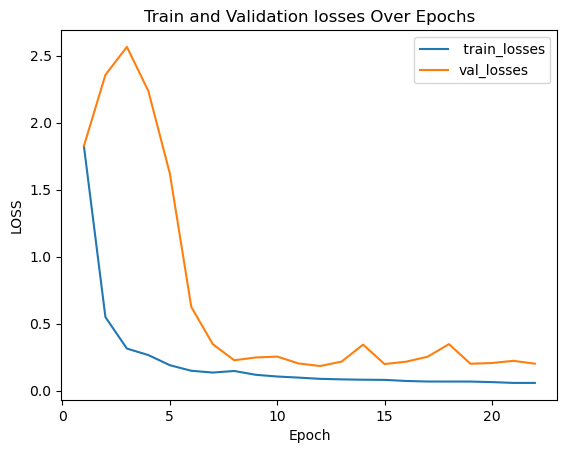

In [ ]:
plt.figure()
plt.plot(range(1, epoch+2), total_train_loss, label=' train_losses')
plt.plot(range(1, epoch+2), total_val_loss, label='val_losses')
plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.legend()
plt.title('Train and Validation losses Over Epochs')
plt.show()

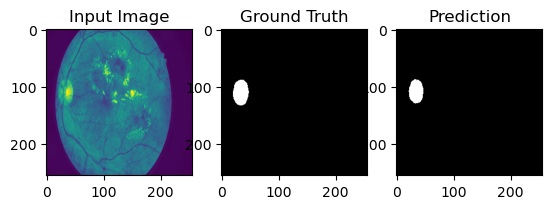

0


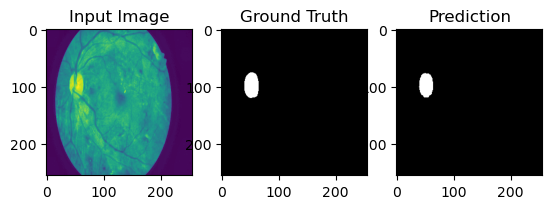

1


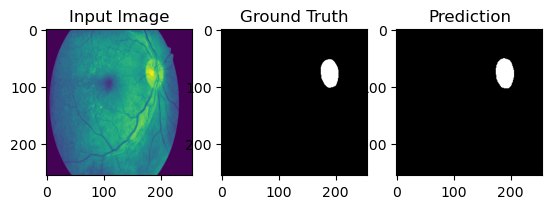

2


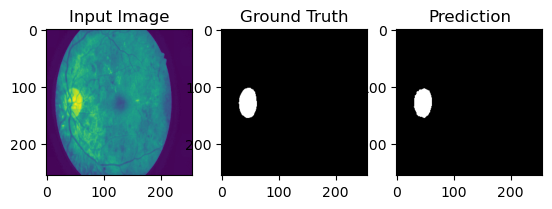

3


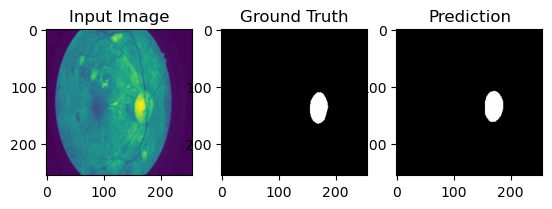

4


In [ ]:
def visualize_predictions(model, loader, device, num_images=5):
    model.eval()
    num_images_plotted = 0
    with torch.no_grad():
        for idx, (images, masks) in enumerate(loader):
            images = images.to(device)
            outputs = model(images)[0]
            preds = torch.sigmoid(outputs) > 0.5
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            for i in range(images.size(0)):
                plt.figure()
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].permute(1, 2, 0).cpu())
                plt.title('Input Image')

                plt.subplot(1, 3, 2)
                plt.imshow(masks[i][0], cmap='gray')
                plt.title('Ground Truth')

                plt.subplot(1, 3, 3)
                plt.imshow(preds[i].transpose(1, 2, 0), cmap='gray')
                plt.title('Prediction')

                plt.show()
                print(i)

                num_images_plotted += i 
                if i+1 >= num_images:
                    break
            
            if idx+1 >= num_images or num_images_plotted >= num_images:
                break

visualize_predictions(model, val_loader, device, num_images=5)


# Testing after Training

In [25]:
import glob
import os
weight_files = sorted(glob.glob(os.path.join(folder_path, "*.pth")))
print(weight_files)

['RESULTS/IDRID_OPTIC_DISC/RUN_1.pth', 'RESULTS/IDRID_OPTIC_DISC/RUN_10.pth', 'RESULTS/IDRID_OPTIC_DISC/RUN_2.pth', 'RESULTS/IDRID_OPTIC_DISC/RUN_3.pth', 'RESULTS/IDRID_OPTIC_DISC/RUN_4.pth', 'RESULTS/IDRID_OPTIC_DISC/RUN_5.pth', 'RESULTS/IDRID_OPTIC_DISC/RUN_6.pth', 'RESULTS/IDRID_OPTIC_DISC/RUN_7.pth', 'RESULTS/IDRID_OPTIC_DISC/RUN_8.pth', 'RESULTS/IDRID_OPTIC_DISC/RUN_9.pth']


In [ ]:
import torch
import numpy as np
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, jaccard_score, accuracy_score,
                             confusion_matrix)

def calculate_iou(pred, target):
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    iou = (intersection + 1e-6) / (union + 1e-6)  
    return iou

def calculate_dice(pred, target):
    intersection = (pred & target).sum()
    dice = (2 * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)
    return dice

def calculate_specificity(pred, target):
    tn, fp, fn, tp = confusion_matrix(target, pred).ravel()
    specificity = tn / (tn + fp + 1e-6)
    return specificity

weight_files = sorted(glob.glob(os.path.join(folder_path, "*.pth")))

all_weight_ious = []
all_weight_dice = []
all_weight_precisions = []
all_weight_recalls = []
all_weight_f1s = []
all_weight_aucs = []
all_weight_jaccard = []
all_weight_accuracies = []
all_weight_specificities = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

output_file = (f'{folder_path}evaluation_results.txt')
with open(output_file, "w") as outfile:
    for idx, weight_file in enumerate(weight_files, start=1):
        MODEL.load_state_dict(torch.load(weight_file, map_location=device))
        MODEL.to(device)
        MODEL.eval()  

        batch_ious = []
        batch_dice = []
        batch_precisions = []
        batch_recalls = []
        batch_f1s = []
        batch_aucs = []
        batch_jaccard = []
        batch_accuracies = []
        batch_specificities = []

        with torch.no_grad():
            for batch in val_loader:
                images, masks = batch
                images = images.to(device)
                masks = masks.to(device)

                outputs = MODEL(images)[0]
                preds = torch.sigmoid(outputs) > 0.5  
                preds = preds.int()
                masks = masks.int()

                preds_np = preds.cpu().numpy().flatten()
                masks_np = masks.cpu().numpy().flatten()

                iou = calculate_iou(preds_np, masks_np)
                dice = calculate_dice(preds_np, masks_np)
                precision = precision_score(masks_np, preds_np, zero_division=1)
                recall = recall_score(masks_np, preds_np, zero_division=1)  
                f1 = f1_score(masks_np, preds_np, zero_division=1)
                jaccard = jaccard_score(masks_np, preds_np, zero_division=1)
                accuracy = accuracy_score(masks_np, preds_np)
                specificity = calculate_specificity(preds_np, masks_np)
                auc = roc_auc_score(masks_np, torch.sigmoid(outputs).cpu().numpy().flatten())

                batch_ious.append(iou)
                batch_dice.append(dice)
                batch_precisions.append(precision)
                batch_recalls.append(recall)
                batch_f1s.append(f1)
                batch_aucs.append(auc)
                batch_jaccard.append(jaccard)
                batch_accuracies.append(accuracy)
                batch_specificities.append(specificity)

        avg_iou = np.mean(batch_ious)
        avg_dice = np.mean(batch_dice)
        avg_precision = np.mean(batch_precisions)
        avg_recall = np.mean(batch_recalls)
        avg_f1 = np.mean(batch_f1s)
        avg_auc = np.mean(batch_aucs)
        avg_jaccard = np.mean(batch_jaccard)
        avg_accuracy = np.mean(batch_accuracies)
        avg_specificity = np.mean(batch_specificities)

        output_str = f"Weight File {idx} ({weight_file}):\n"
        output_str += f"  Average IoU: {avg_iou:.4f}\n"
        output_str += f"  Average Dice Coefficient: {avg_dice:.4f}\n"
        output_str += f"  Average Precision: {avg_precision:.4f}\n"
        output_str += f"  Average Recall (Sensitivity): {avg_recall:.4f}\n"
        output_str += f"  Average F1 Score: {avg_f1:.4f}\n"
        output_str += f"  Average AUC: {avg_auc:.4f}\n"
        output_str += f"  Average Jaccard Score: {avg_jaccard:.4f}\n"
        output_str += f"  Average Accuracy: {avg_accuracy:.4f}\n"
        output_str += f"  Average Specificity: {avg_specificity:.4f}\n\n"

        print(output_str)
        outfile.write(output_str)

        all_weight_ious.append(avg_iou)
        all_weight_dice.append(avg_dice)
        all_weight_precisions.append(avg_precision)
        all_weight_recalls.append(avg_recall)
        all_weight_f1s.append(avg_f1)
        all_weight_aucs.append(avg_auc)
        all_weight_jaccard.append(avg_jaccard)
        all_weight_accuracies.append(avg_accuracy)
        all_weight_specificities.append(avg_specificity)

    overall_str = "Overall Metrics Across All Weight Files:\n"
    overall_str += f"Mean IoU: {np.mean(all_weight_ious):.4f}, Std IoU: {np.std(all_weight_ious):.4f}\n"
    overall_str += f"Mean Dice Coefficient: {np.mean(all_weight_dice):.4f}, Std Dice: {np.std(all_weight_dice):.4f}\n"
    overall_str += f"Mean Precision: {np.mean(all_weight_precisions):.4f}, Std Precision: {np.std(all_weight_precisions):.4f}\n"
    overall_str += f"Mean Recall (Sensitivity): {np.mean(all_weight_recalls):.4f}, Std Recall: {np.std(all_weight_recalls):.4f}\n"
    overall_str += f"Mean F1 Score: {np.mean(all_weight_f1s):.4f}, Std F1: {np.std(all_weight_f1s):.4f}\n"
    overall_str += f"Mean AUC: {np.mean(all_weight_aucs):.4f}, Std AUC: {np.std(all_weight_aucs):.4f}\n"
    overall_str += f"Mean Jaccard Score: {np.mean(all_weight_jaccard):.4f}, Std Jaccard: {np.std(all_weight_jaccard):.4f}\n"
    overall_str += f"Mean Accuracy: {np.mean(all_weight_accuracies):.4f}, Std Accuracy: {np.std(all_weight_accuracies):.4f}\n"
    overall_str += f"Mean Specificity: {np.mean(all_weight_specificities):.4f}, Std Specificity: {np.std(all_weight_specificities):.4f}\n"

    print(overall_str)
    outfile.write(overall_str)

Weight File 1 (RESULTS/IDRID_OPTIC_DISC/RUN_1.pth):
  Average IoU: 0.9047
  Average Dice Coefficient: 0.9500
  Average Precision: 0.9603
  Average Recall (Sensitivity): 0.9399
  Average F1 Score: 0.9500
  Average AUC: 0.9998
  Average Jaccard Score: 0.9047
  Average Accuracy: 0.9983
  Average Specificity: 0.9993


Weight File 2 (RESULTS/IDRID_OPTIC_DISC/RUN_10.pth):
  Average IoU: 0.8337
  Average Dice Coefficient: 0.9093
  Average Precision: 0.8731
  Average Recall (Sensitivity): 0.9486
  Average F1 Score: 0.9093
  Average AUC: 0.9995
  Average Jaccard Score: 0.8337
  Average Accuracy: 0.9967
  Average Specificity: 0.9976


Weight File 3 (RESULTS/IDRID_OPTIC_DISC/RUN_2.pth):
  Average IoU: 0.8857
  Average Dice Coefficient: 0.9394
  Average Precision: 0.9418
  Average Recall (Sensitivity): 0.9370
  Average F1 Score: 0.9394
  Average AUC: 0.9998
  Average Jaccard Score: 0.8857
  Average Accuracy: 0.9979
  Average Specificity: 0.9990


Weight File 4 (RESULTS/IDRID_OPTIC_DISC/RUN_3.pth):